In [2]:
import tensorflow as tf
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [5]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.shape) for p in model.weights])
    return param_count

answers = np.load('input\cs231n-gan\gan-checks-tf.npz')

NOISE_DIM = 96

In [6]:
class MNIST(object):
    def __init__(self, batch_size, shuffle=False):
        """
        Construct an iterator object over the MNIST data
        
        Inputs:
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        train, _ = tf.keras.datasets.mnist.load_data()
        X, y = train
        X = X.astype(np.float32)/255
        X = X.reshape((X.shape[0], -1))
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B)) 

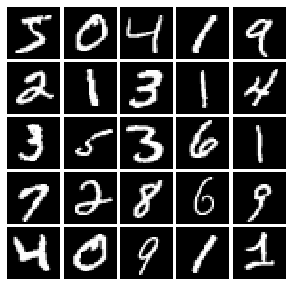

In [7]:
# show a batch
mnist = MNIST(batch_size=25) 
show_images(mnist.X[:25])

In [8]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    x = tf.nn.leaky_relu(x,alpha)
    return x
    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

In [9]:
def test_leaky_relu(x, y_true):
    y = leaky_relu(tf.constant(x))
    print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 1.11759e-08


In [10]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    noise = tf.random.uniform([batch_size,dim],minval = -1,maxval = 1)
    return noise
    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

In [11]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    z = sample_noise(batch_size, dim)
    # Check z has the correct shape
    assert z.get_shape().as_list() == [batch_size, dim]
    # Make sure z is a Tensor and not a numpy array
    assert isinstance(z, tf.Tensor)
    # Check that we get different noise for different evaluations
    z1 = sample_noise(batch_size, dim)
    z2 = sample_noise(batch_size, dim)
    assert not np.array_equal(z1, z2)
    # Check that we get the correct range
    assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
    print("All tests passed!")
    
test_sample_noise()

All tests passed!


In [12]:
def discriminator():
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    model = tf.keras.models.Sequential([
        # TODO: implement architecture
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        tf.keras.layers.InputLayer(784),
        tf.keras.layers.Dense(256),
        tf.keras.layers.LeakyReLU(0.01),
        tf.keras.layers.Dense(256),
        tf.keras.layers.LeakyReLU(0.01),
        tf.keras.layers.Dense(1)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ])
    return model

In [13]:
def test_discriminator(true_count=267009):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
    else:
        print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


In [15]:
def generator(noise_dim=NOISE_DIM):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    model = tf.keras.models.Sequential([
        # TODO: implement architecture
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        tf.keras.layers.InputLayer(noise_dim),
        tf.keras.layers.Dense(1024),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(1024),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(784,activation = tf.nn.tanh)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ])
    return model

In [16]:
def test_generator(true_count=1858320):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
    else:
        print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


In [32]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: Tensor of shape (N, 1) giving scores for the real data.
    - logits_fake: Tensor of shape (N, 1) giving scores for the fake data.
    
    Returns:
    - loss: Tensor containing (scalar) the loss for the discriminator.
    """
    loss = None
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    real_loss = cross_entropy(tf.ones_like(logits_real), logits_real)
    fake_loss = cross_entropy(tf.zeros_like(logits_fake), logits_fake)
    loss = real_loss + fake_loss
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    loss = None
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    loss = cross_entropy(tf.ones_like(logits_fake), logits_fake)
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

In [34]:
def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(tf.constant(logits_real),
                                tf.constant(logits_fake))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
                        answers['d_loss_true'])

Maximum error in d_loss: 0


In [35]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(tf.constant(logits_fake))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(answers['logits_fake'], answers['g_loss_true'])

Maximum error in g_loss: 7.19722e-17


In [36]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.optimizers.Adam with correct learning_rate and beta1
    - G_solver: instance of tf.optimizers.Adam with correct learning_rate and beta1
    """
    D_solver = None
    G_solver = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    D_solver = tf.optimizers.Adam(learning_rate,beta1)
    G_solver = tf.optimizers.Adam(learning_rate,beta1)
    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return D_solver, G_solver

In [37]:
# a giant helper function
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss,\
              show_every=20, print_every=20, batch_size=128, num_epochs=10, noise_size=96):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - D: Discriminator model
    - G: Generator model
    - D_solver: an Optimizer for Discriminator
    - G_solver: an Optimizer for Generator
    - generator_loss: Generator loss
    - discriminator_loss: Discriminator loss
    Returns:
        Nothing
    """
    mnist = MNIST(batch_size=batch_size, shuffle=True)
    
    iter_count = 0
    for epoch in range(num_epochs):
        for (x, _) in mnist:
            with tf.GradientTape() as tape:
                real_data = x
                logits_real = D(preprocess_img(real_data))

                g_fake_seed = sample_noise(batch_size, noise_size)
                fake_images = G(g_fake_seed)
                logits_fake = D(tf.reshape(fake_images, [batch_size, 784]))

                d_total_error = discriminator_loss(logits_real, logits_fake)
                d_gradients = tape.gradient(d_total_error, D.trainable_variables)      
                D_solver.apply_gradients(zip(d_gradients, D.trainable_variables))
            
            with tf.GradientTape() as tape:
                g_fake_seed = sample_noise(batch_size, noise_size)
                fake_images = G(g_fake_seed)

                gen_logits_fake = D(tf.reshape(fake_images, [batch_size, 784]))
                g_error = generator_loss(gen_logits_fake)
                g_gradients = tape.gradient(g_error, G.trainable_variables)      
                G_solver.apply_gradients(zip(g_gradients, G.trainable_variables))

            if (iter_count % show_every == 0):
                print('Epoch: {}, Iter: {}, D: {:.4}, G:{:.4}'.format(epoch, iter_count,d_total_error,g_error))
                imgs_numpy = fake_images.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
            iter_count += 1
    
    # random noise fed into our generator
    z = sample_noise(batch_size, noise_size)
    # generated images
    G_sample = G(z)
    print('Final images')
    show_images(G_sample[:16])
    plt.show()

Epoch: 0, Iter: 0, D: 1.364, G:0.697
Instructions for updating:
Use tf.identity instead.


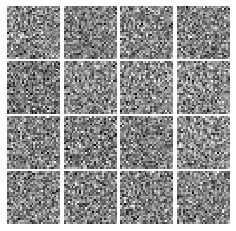

Epoch: 0, Iter: 20, D: 0.586, G:1.017


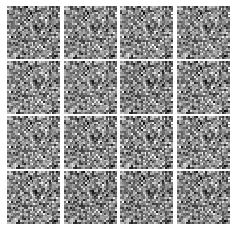

Epoch: 0, Iter: 40, D: 0.4337, G:1.152


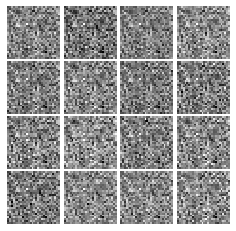

Epoch: 0, Iter: 60, D: 0.1225, G:2.604


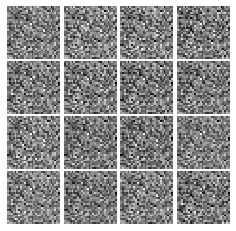

Epoch: 0, Iter: 80, D: 2.359, G:1.653


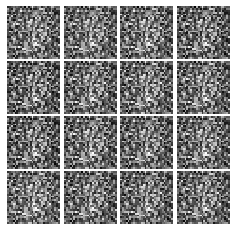

Epoch: 0, Iter: 100, D: 1.05, G:1.389


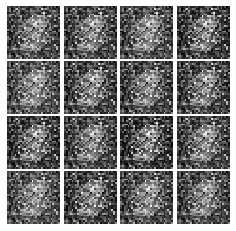

Epoch: 0, Iter: 120, D: 1.441, G:1.466


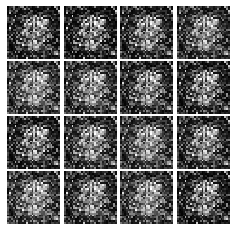

Epoch: 0, Iter: 140, D: 1.509, G:1.504


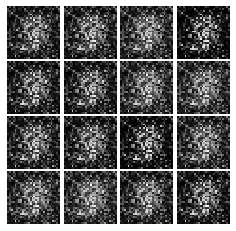

Epoch: 0, Iter: 160, D: 1.267, G:1.049


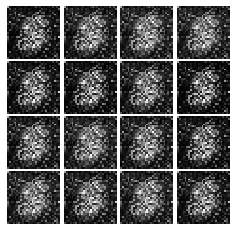

Epoch: 0, Iter: 180, D: 1.321, G:1.7


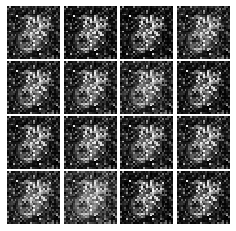

Epoch: 0, Iter: 200, D: 1.524, G:1.016


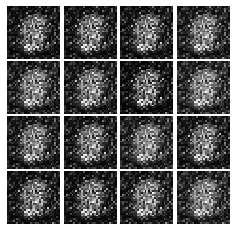

Epoch: 0, Iter: 220, D: 0.7245, G:2.272


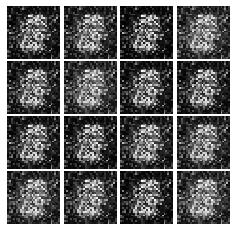

Epoch: 0, Iter: 240, D: 1.015, G:1.386


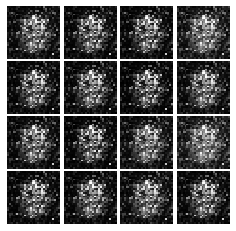

Epoch: 0, Iter: 260, D: 1.223, G:1.379


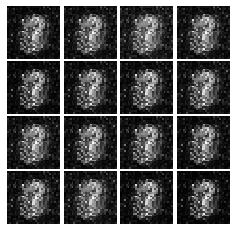

Epoch: 0, Iter: 280, D: 0.9664, G:1.363


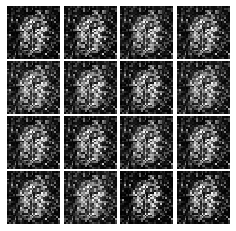

Epoch: 0, Iter: 300, D: 1.5, G:1.35


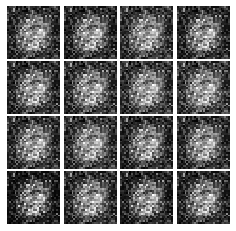

Epoch: 0, Iter: 320, D: 1.11, G:1.565


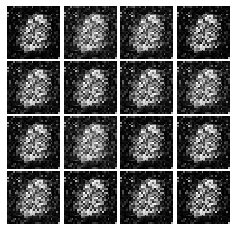

Epoch: 0, Iter: 340, D: 0.9286, G:1.341


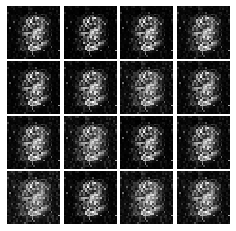

Epoch: 0, Iter: 360, D: 0.8635, G:1.668


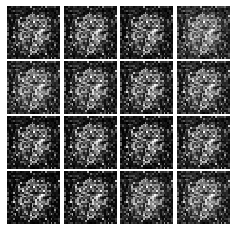

Epoch: 0, Iter: 380, D: 0.8314, G:1.796


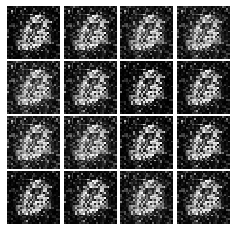

Epoch: 0, Iter: 400, D: 1.499, G:1.971


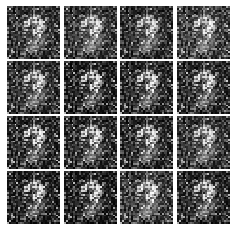

Epoch: 0, Iter: 420, D: 1.304, G:1.308


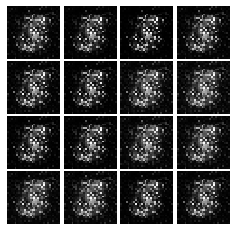

Epoch: 0, Iter: 440, D: 0.9509, G:1.297


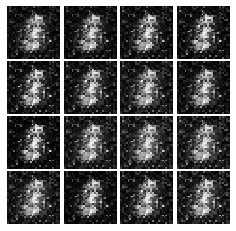

Epoch: 0, Iter: 460, D: 0.8226, G:2.105


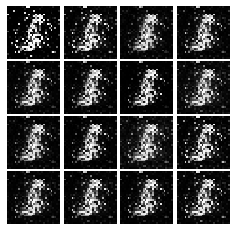

Epoch: 1, Iter: 480, D: 0.9619, G:0.4851


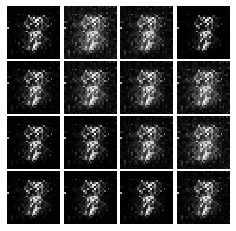

Epoch: 1, Iter: 500, D: 2.032, G:1.679


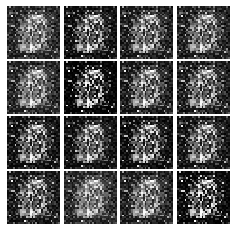

Epoch: 1, Iter: 520, D: 1.63, G:2.147


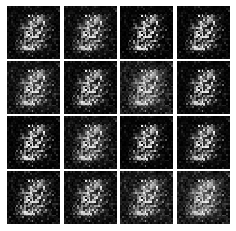

Epoch: 1, Iter: 540, D: 1.588, G:1.445


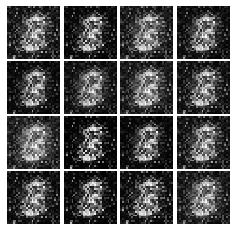

Epoch: 1, Iter: 560, D: 1.406, G:1.604


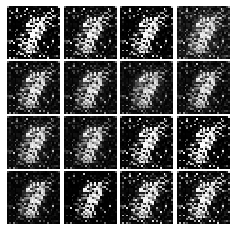

Epoch: 1, Iter: 580, D: 1.641, G:0.2524


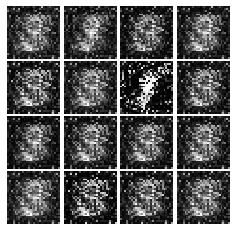

Epoch: 1, Iter: 600, D: 1.242, G:2.311


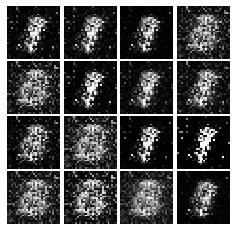

Epoch: 1, Iter: 620, D: 1.104, G:0.8897


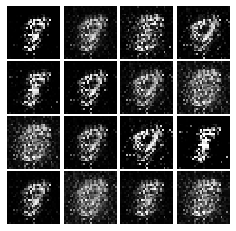

Epoch: 1, Iter: 640, D: 1.056, G:1.302


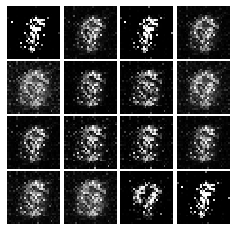

Epoch: 1, Iter: 660, D: 1.146, G:1.502


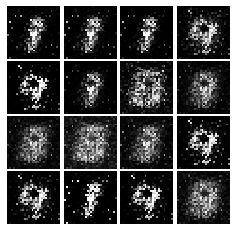

Epoch: 1, Iter: 680, D: 1.058, G:1.095


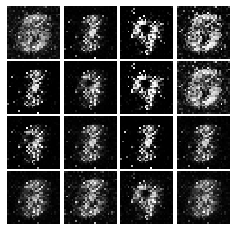

Epoch: 1, Iter: 700, D: 1.219, G:1.044


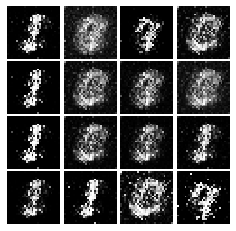

Epoch: 1, Iter: 720, D: 1.295, G:0.9578


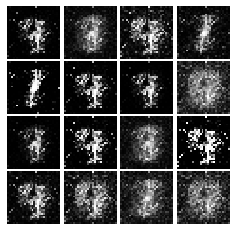

Epoch: 1, Iter: 740, D: 1.124, G:1.312


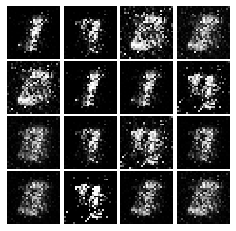

Epoch: 1, Iter: 760, D: 1.063, G:1.498


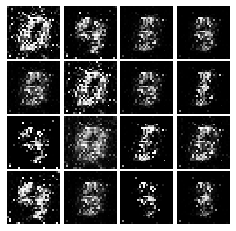

Epoch: 1, Iter: 780, D: 0.9346, G:2.617


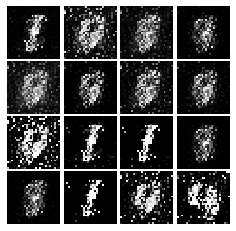

Epoch: 1, Iter: 800, D: 1.074, G:1.439


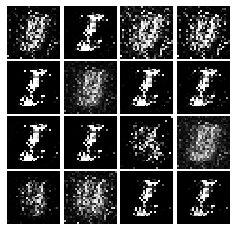

Epoch: 1, Iter: 820, D: 1.097, G:1.568


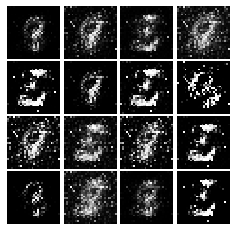

Epoch: 1, Iter: 840, D: 1.078, G:1.334


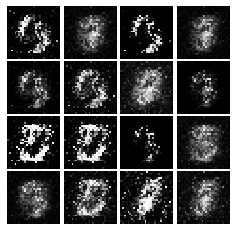

Epoch: 1, Iter: 860, D: 1.497, G:1.162


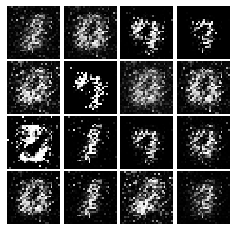

Epoch: 1, Iter: 880, D: 1.118, G:1.229


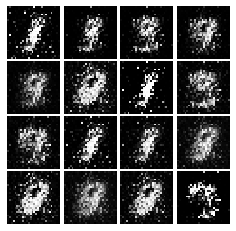

Epoch: 1, Iter: 900, D: 0.9146, G:1.553


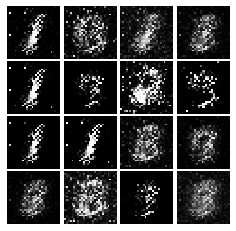

Epoch: 1, Iter: 920, D: 1.166, G:1.291


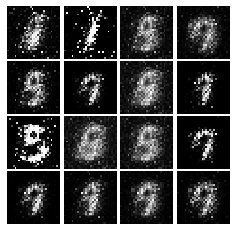

Epoch: 2, Iter: 940, D: 1.303, G:1.047


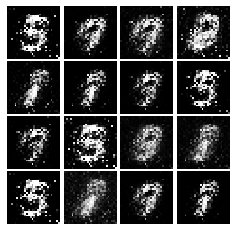

Epoch: 2, Iter: 960, D: 0.9317, G:1.332


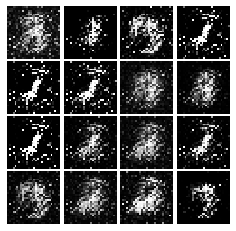

Epoch: 2, Iter: 980, D: 1.227, G:1.657


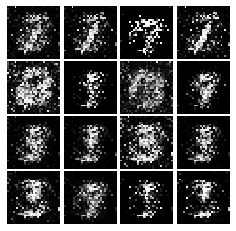

Epoch: 2, Iter: 1000, D: 1.201, G:1.79


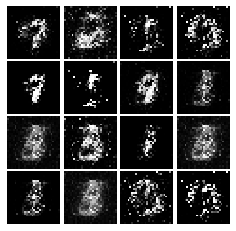

Epoch: 2, Iter: 1020, D: 1.086, G:1.555


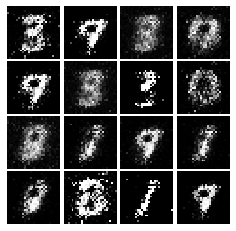

Epoch: 2, Iter: 1040, D: 0.9409, G:1.376


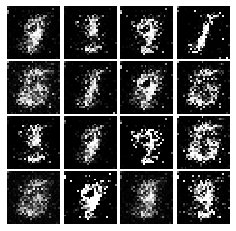

Epoch: 2, Iter: 1060, D: 1.1, G:1.253


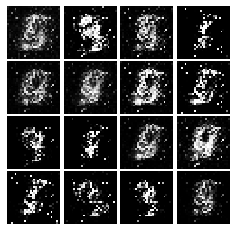

Epoch: 2, Iter: 1080, D: 0.8836, G:1.749


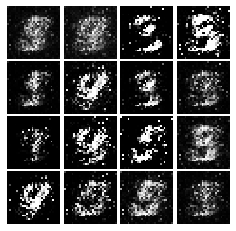

Epoch: 2, Iter: 1100, D: 1.06, G:1.782


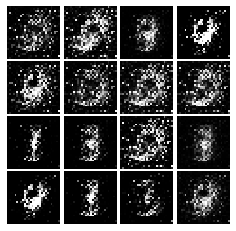

Epoch: 2, Iter: 1120, D: 1.74, G:0.8758


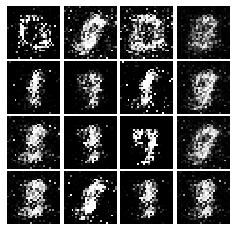

Epoch: 2, Iter: 1140, D: 1.056, G:1.221


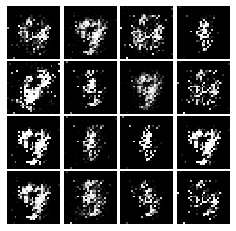

Epoch: 2, Iter: 1160, D: 1.347, G:1.698


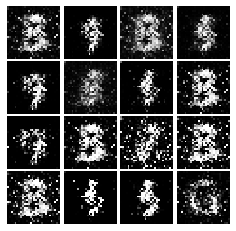

Epoch: 2, Iter: 1180, D: 1.445, G:2.872


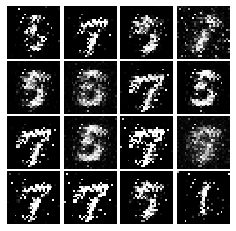

Epoch: 2, Iter: 1200, D: 1.114, G:1.822


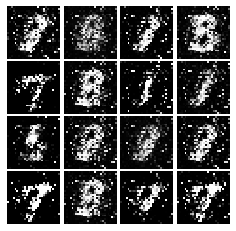

Epoch: 2, Iter: 1220, D: 1.407, G:2.751


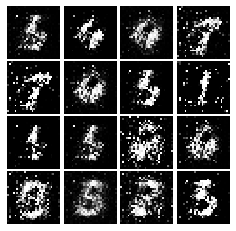

Epoch: 2, Iter: 1240, D: 2.206, G:2.213


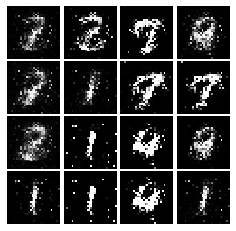

Epoch: 2, Iter: 1260, D: 1.308, G:1.582


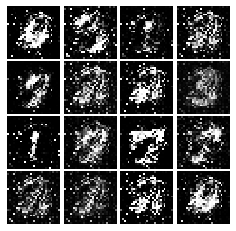

Epoch: 2, Iter: 1280, D: 1.046, G:1.402


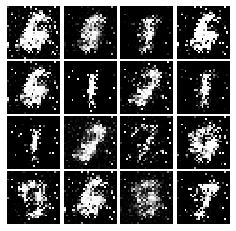

Epoch: 2, Iter: 1300, D: 1.162, G:1.1


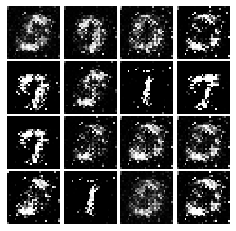

Epoch: 2, Iter: 1320, D: 1.514, G:0.8922


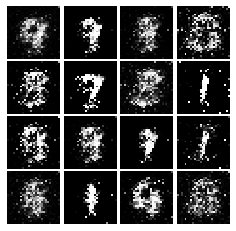

Epoch: 2, Iter: 1340, D: 1.136, G:1.252


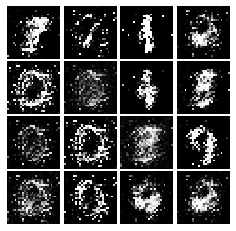

Epoch: 2, Iter: 1360, D: 1.069, G:1.419


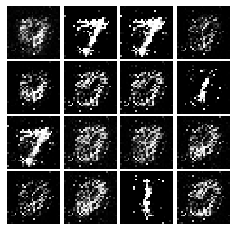

Epoch: 2, Iter: 1380, D: 0.9868, G:1.261


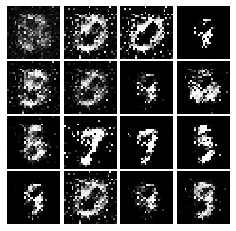

Epoch: 2, Iter: 1400, D: 1.06, G:1.123


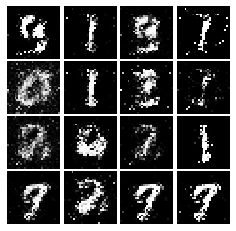

Epoch: 3, Iter: 1420, D: 1.16, G:0.9395


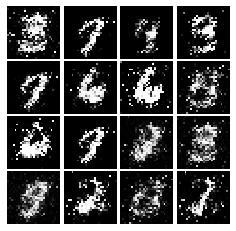

Epoch: 3, Iter: 1440, D: 1.221, G:1.33


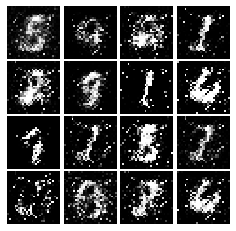

Epoch: 3, Iter: 1460, D: 1.308, G:1.033


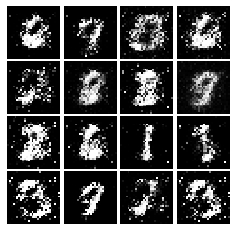

Epoch: 3, Iter: 1480, D: 1.127, G:1.108


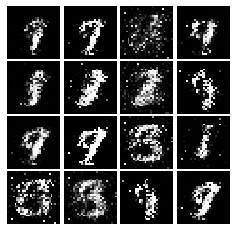

Epoch: 3, Iter: 1500, D: 1.087, G:0.9777


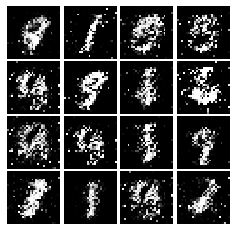

Epoch: 3, Iter: 1520, D: 1.218, G:1.651


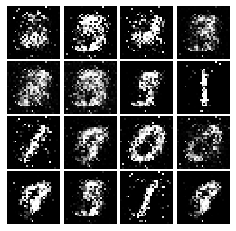

Epoch: 3, Iter: 1540, D: 1.114, G:1.12


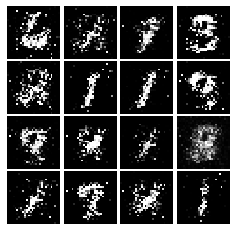

Epoch: 3, Iter: 1560, D: 1.217, G:1.17


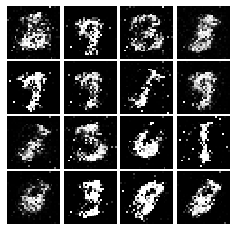

Epoch: 3, Iter: 1580, D: 0.9477, G:3.86


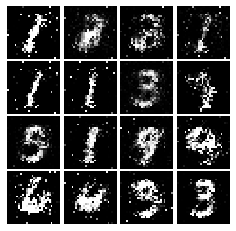

Epoch: 3, Iter: 1600, D: 1.272, G:1.069


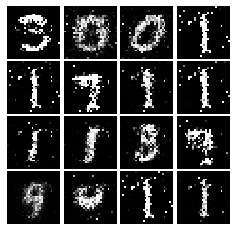

Epoch: 3, Iter: 1620, D: 1.182, G:1.138


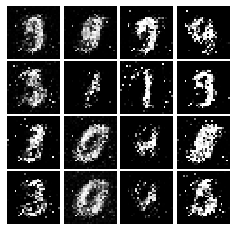

Epoch: 3, Iter: 1640, D: 1.124, G:1.151


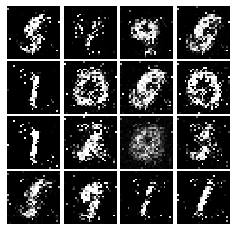

Epoch: 3, Iter: 1660, D: 1.486, G:1.004


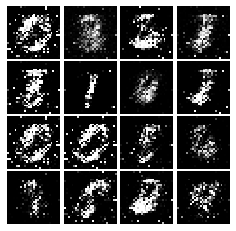

Epoch: 3, Iter: 1680, D: 1.233, G:1.268


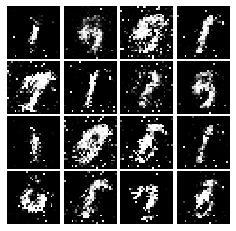

Epoch: 3, Iter: 1700, D: 1.364, G:0.9469


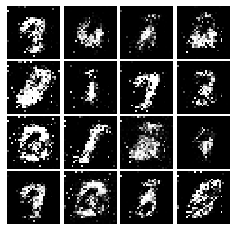

Epoch: 3, Iter: 1720, D: 1.315, G:0.9543


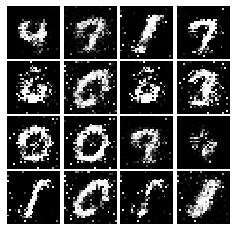

Epoch: 3, Iter: 1740, D: 1.229, G:1.187


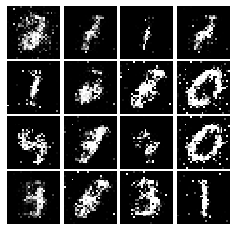

Epoch: 3, Iter: 1760, D: 1.022, G:1.102


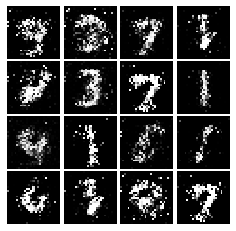

Epoch: 3, Iter: 1780, D: 1.212, G:0.9527


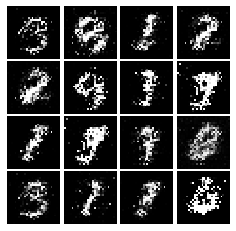

Epoch: 3, Iter: 1800, D: 1.295, G:0.9033


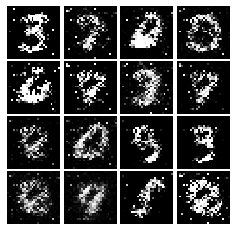

Epoch: 3, Iter: 1820, D: 1.152, G:0.9495


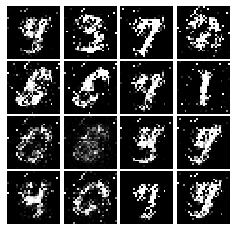

Epoch: 3, Iter: 1840, D: 1.202, G:0.8702


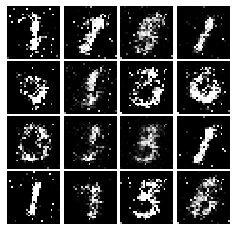

Epoch: 3, Iter: 1860, D: 1.172, G:1.04


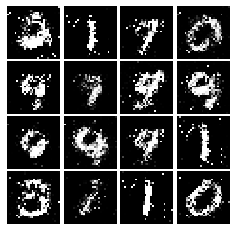

Epoch: 4, Iter: 1880, D: 1.243, G:0.9768


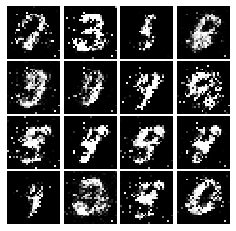

Epoch: 4, Iter: 1900, D: 1.315, G:1.158


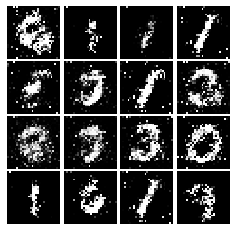

Epoch: 4, Iter: 1920, D: 1.111, G:1.274


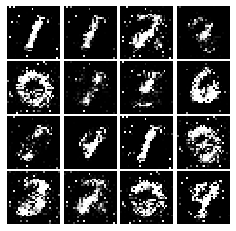

Epoch: 4, Iter: 1940, D: 1.223, G:1.192


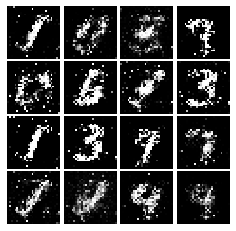

Epoch: 4, Iter: 1960, D: 1.305, G:1.084


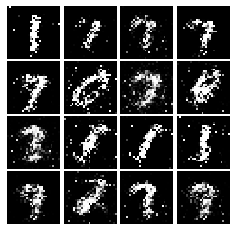

Epoch: 4, Iter: 1980, D: 1.322, G:0.9248


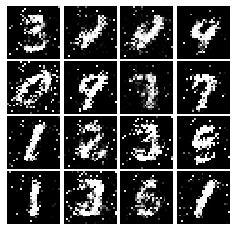

Epoch: 4, Iter: 2000, D: 1.403, G:2.032


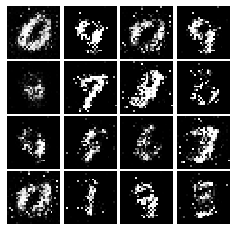

Epoch: 4, Iter: 2020, D: 1.34, G:0.7631


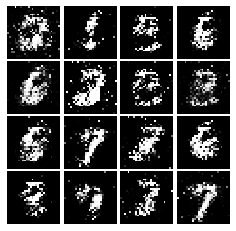

Epoch: 4, Iter: 2040, D: 1.322, G:0.7842


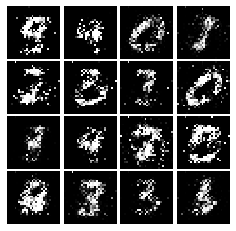

Epoch: 4, Iter: 2060, D: 1.364, G:0.9037


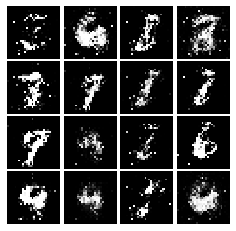

Epoch: 4, Iter: 2080, D: 1.249, G:0.8016


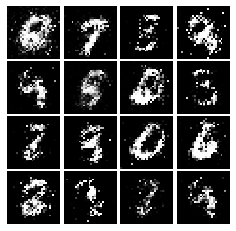

Epoch: 4, Iter: 2100, D: 1.287, G:0.9444


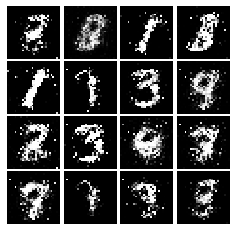

Epoch: 4, Iter: 2120, D: 1.227, G:0.9604


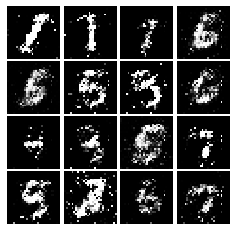

Epoch: 4, Iter: 2140, D: 1.187, G:0.9689


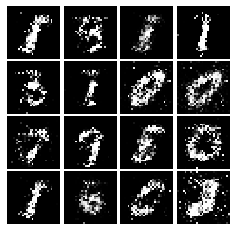

Epoch: 4, Iter: 2160, D: 1.299, G:1.029


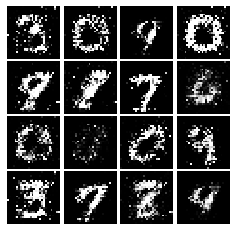

Epoch: 4, Iter: 2180, D: 1.295, G:1.039


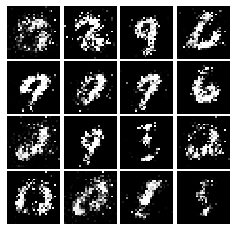

Epoch: 4, Iter: 2200, D: 1.302, G:0.8639


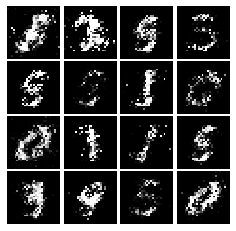

Epoch: 4, Iter: 2220, D: 1.213, G:0.9687


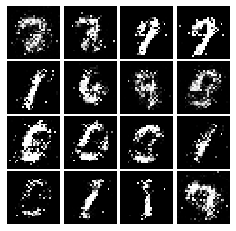

Epoch: 4, Iter: 2240, D: 1.28, G:0.9405


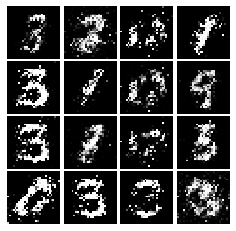

Epoch: 4, Iter: 2260, D: 1.281, G:0.8424


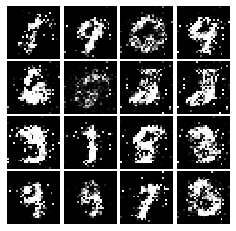

Epoch: 4, Iter: 2280, D: 1.306, G:0.8213


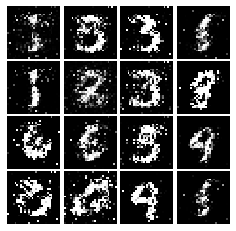

Epoch: 4, Iter: 2300, D: 1.293, G:0.8873


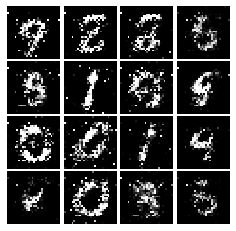

Epoch: 4, Iter: 2320, D: 1.212, G:0.8814


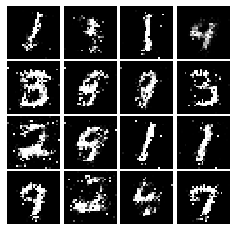

Epoch: 4, Iter: 2340, D: 1.173, G:0.9015


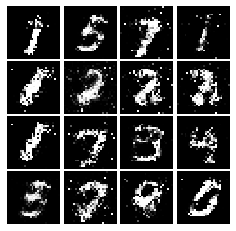

Epoch: 5, Iter: 2360, D: 1.371, G:0.8969


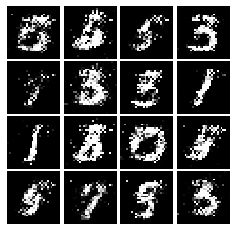

Epoch: 5, Iter: 2380, D: 1.233, G:0.8336


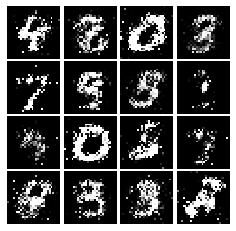

Epoch: 5, Iter: 2400, D: 1.163, G:0.9995


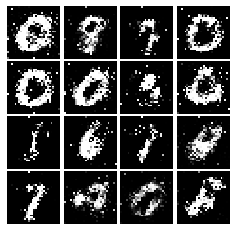

Epoch: 5, Iter: 2420, D: 1.155, G:1.198


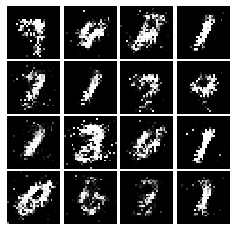

Epoch: 5, Iter: 2440, D: 1.361, G:0.8933


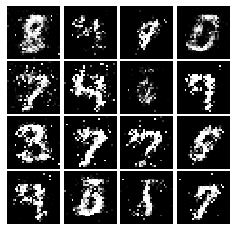

Epoch: 5, Iter: 2460, D: 1.263, G:0.8735


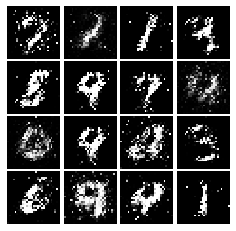

Epoch: 5, Iter: 2480, D: 1.394, G:0.8131


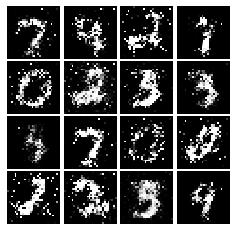

Epoch: 5, Iter: 2500, D: 1.224, G:0.9436


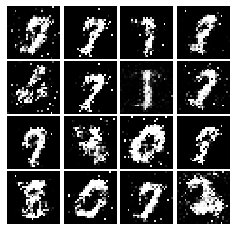

Epoch: 5, Iter: 2520, D: 1.374, G:0.5203


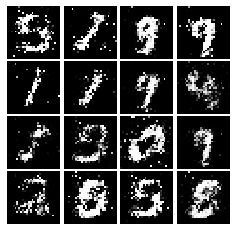

Epoch: 5, Iter: 2540, D: 1.319, G:0.7894


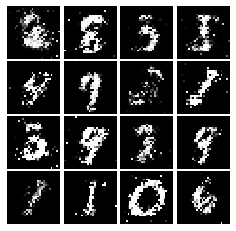

Epoch: 5, Iter: 2560, D: 1.353, G:0.8478


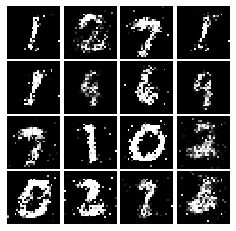

Epoch: 5, Iter: 2580, D: 1.3, G:1.266


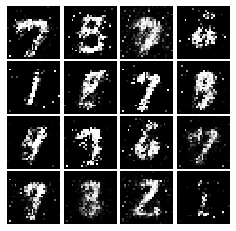

Epoch: 5, Iter: 2600, D: 1.378, G:0.8463


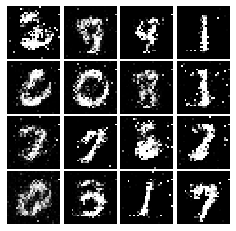

Epoch: 5, Iter: 2620, D: 1.333, G:0.8014


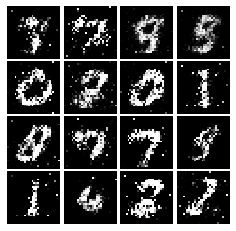

Epoch: 5, Iter: 2640, D: 1.378, G:0.942


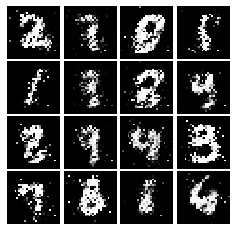

Epoch: 5, Iter: 2660, D: 1.306, G:0.878


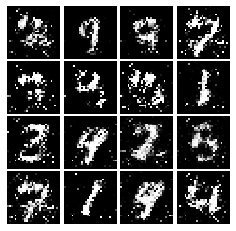

Epoch: 5, Iter: 2680, D: 1.467, G:0.9067


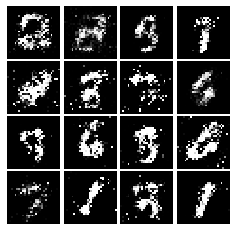

Epoch: 5, Iter: 2700, D: 1.384, G:0.7846


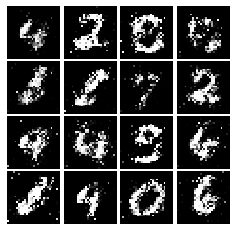

Epoch: 5, Iter: 2720, D: 1.308, G:0.8436


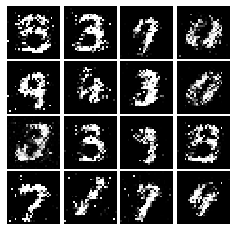

Epoch: 5, Iter: 2740, D: 1.306, G:0.78


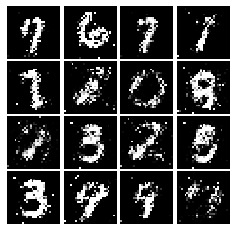

Epoch: 5, Iter: 2760, D: 1.383, G:0.9652


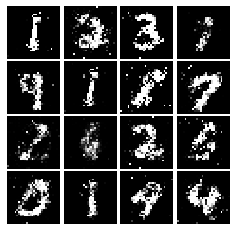

Epoch: 5, Iter: 2780, D: 1.356, G:0.8


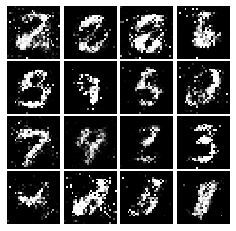

Epoch: 5, Iter: 2800, D: 1.229, G:0.8361


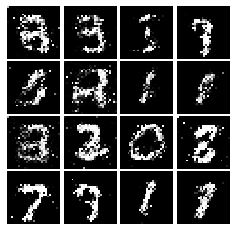

Epoch: 6, Iter: 2820, D: 1.304, G:0.817


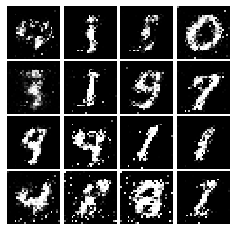

Epoch: 6, Iter: 2840, D: 1.279, G:0.8604


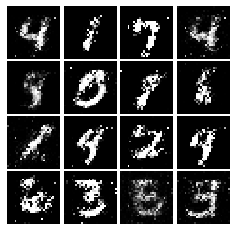

Epoch: 6, Iter: 2860, D: 1.217, G:1.035


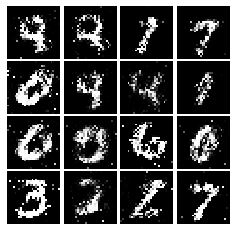

Epoch: 6, Iter: 2880, D: 1.239, G:0.9665


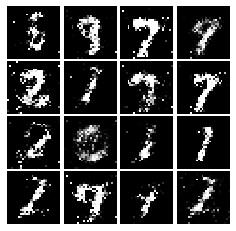

Epoch: 6, Iter: 2900, D: 1.335, G:0.865


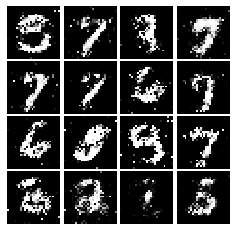

Epoch: 6, Iter: 2920, D: 1.315, G:0.9207


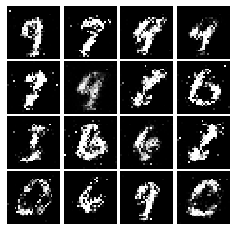

Epoch: 6, Iter: 2940, D: 1.282, G:0.8475


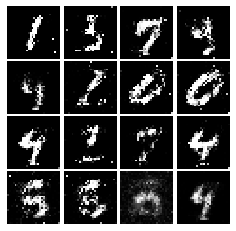

Epoch: 6, Iter: 2960, D: 1.376, G:0.9053


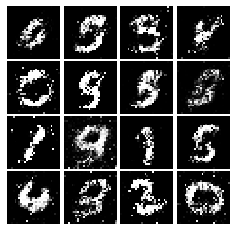

Epoch: 6, Iter: 2980, D: 1.323, G:0.902


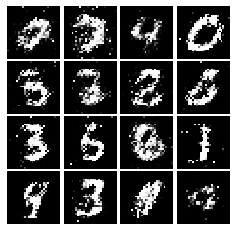

Epoch: 6, Iter: 3000, D: 1.413, G:0.8916


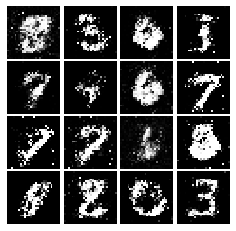

Epoch: 6, Iter: 3020, D: 1.32, G:0.8334


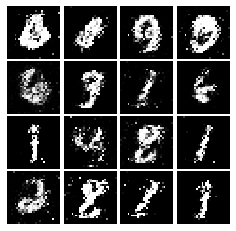

Epoch: 6, Iter: 3040, D: 1.376, G:0.7734


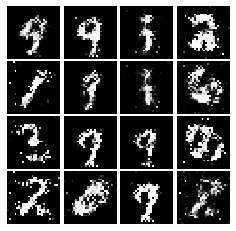

Epoch: 6, Iter: 3060, D: 1.232, G:0.8412


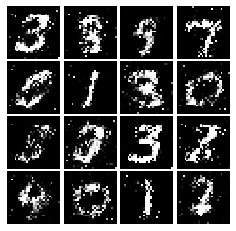

Epoch: 6, Iter: 3080, D: 1.297, G:0.9016


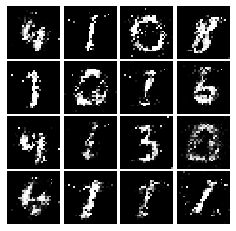

Epoch: 6, Iter: 3100, D: 1.298, G:0.7303


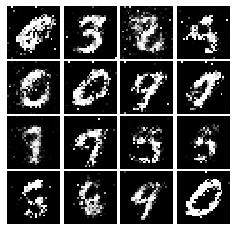

Epoch: 6, Iter: 3120, D: 1.273, G:0.8591


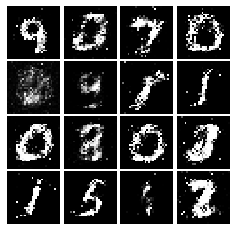

Epoch: 6, Iter: 3140, D: 1.402, G:0.7056


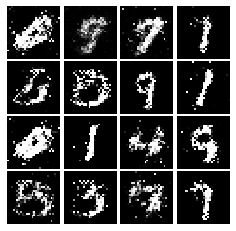

Epoch: 6, Iter: 3160, D: 1.291, G:0.8696


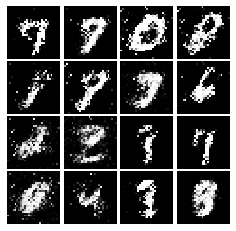

Epoch: 6, Iter: 3180, D: 1.314, G:0.7794


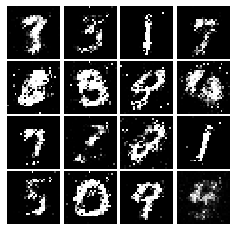

Epoch: 6, Iter: 3200, D: 1.324, G:0.6659


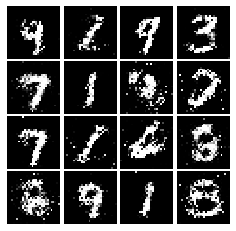

Epoch: 6, Iter: 3220, D: 1.309, G:0.9843


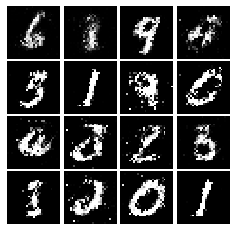

Epoch: 6, Iter: 3240, D: 1.355, G:0.7762


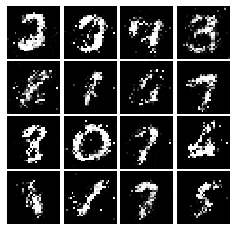

Epoch: 6, Iter: 3260, D: 1.432, G:0.7806


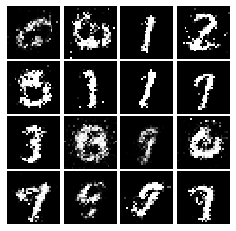

Epoch: 6, Iter: 3280, D: 1.36, G:0.8526


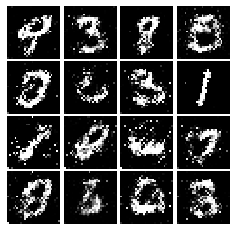

Epoch: 7, Iter: 3300, D: 1.274, G:0.84


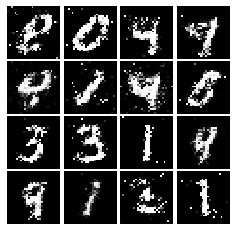

Epoch: 7, Iter: 3320, D: 1.292, G:0.8063


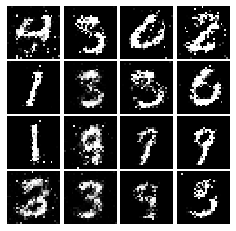

Epoch: 7, Iter: 3340, D: 1.368, G:0.904


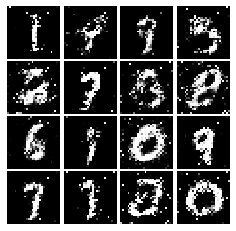

Epoch: 7, Iter: 3360, D: 1.34, G:0.801


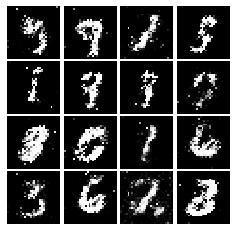

Epoch: 7, Iter: 3380, D: 1.298, G:0.8281


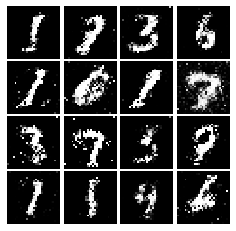

Epoch: 7, Iter: 3400, D: 1.383, G:0.8752


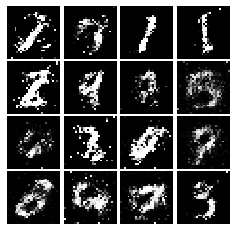

Epoch: 7, Iter: 3420, D: 1.304, G:0.8644


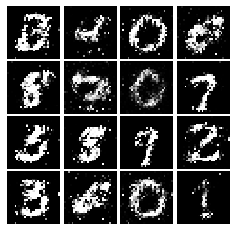

Epoch: 7, Iter: 3440, D: 1.303, G:0.6572


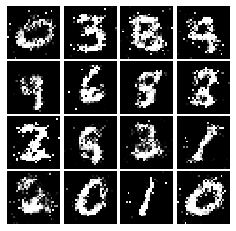

Epoch: 7, Iter: 3460, D: 1.268, G:0.825


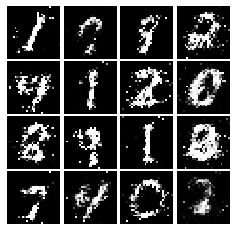

Epoch: 7, Iter: 3480, D: 1.32, G:0.8007


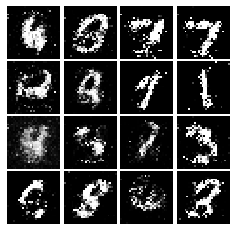

Epoch: 7, Iter: 3500, D: 1.393, G:0.8196


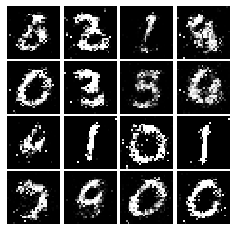

Epoch: 7, Iter: 3520, D: 1.274, G:0.7966


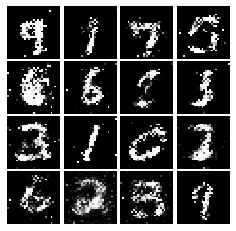

Epoch: 7, Iter: 3540, D: 1.269, G:0.8227


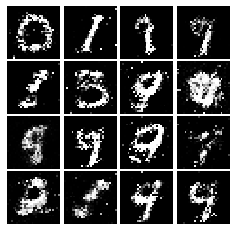

Epoch: 7, Iter: 3560, D: 1.24, G:0.8472


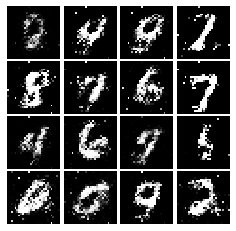

Epoch: 7, Iter: 3580, D: 1.278, G:0.7752


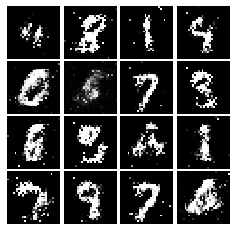

Epoch: 7, Iter: 3600, D: 1.303, G:0.9535


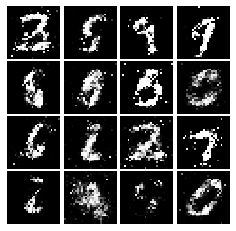

Epoch: 7, Iter: 3620, D: 1.312, G:0.8683


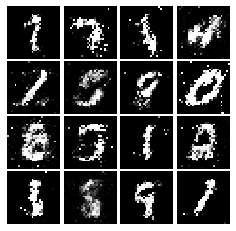

Epoch: 7, Iter: 3640, D: 1.269, G:0.8247


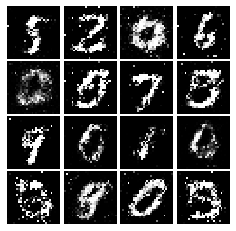

Epoch: 7, Iter: 3660, D: 1.288, G:0.8544


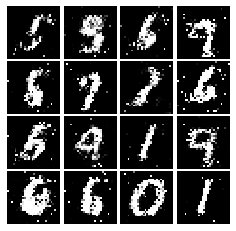

Epoch: 7, Iter: 3680, D: 1.283, G:0.7596


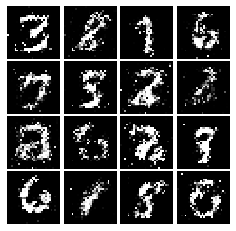

Epoch: 7, Iter: 3700, D: 1.336, G:0.8501


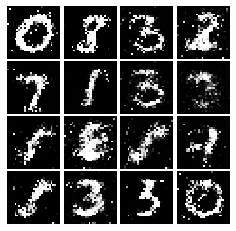

Epoch: 7, Iter: 3720, D: 1.372, G:0.7791


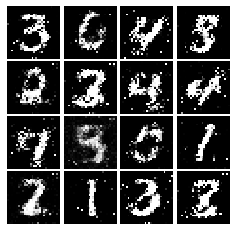

Epoch: 7, Iter: 3740, D: 1.341, G:0.7698


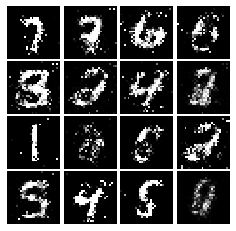

Epoch: 8, Iter: 3760, D: 1.341, G:0.8016


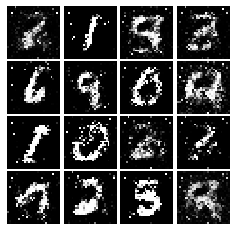

Epoch: 8, Iter: 3780, D: 1.35, G:0.7866


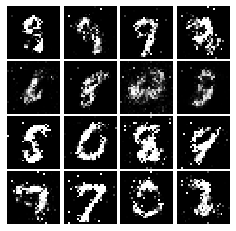

Epoch: 8, Iter: 3800, D: 1.32, G:0.7771


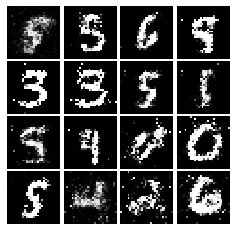

Epoch: 8, Iter: 3820, D: 1.282, G:0.8297


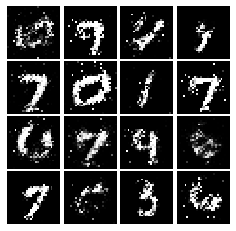

Epoch: 8, Iter: 3840, D: 1.353, G:0.7796


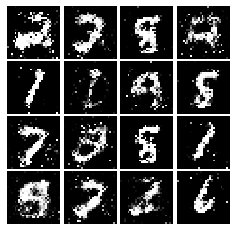

Epoch: 8, Iter: 3860, D: 1.323, G:0.861


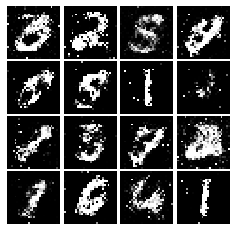

Epoch: 8, Iter: 3880, D: 1.351, G:0.8404


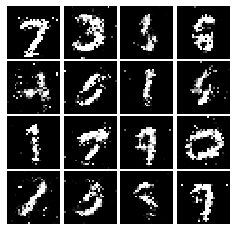

Epoch: 8, Iter: 3900, D: 1.385, G:0.8182


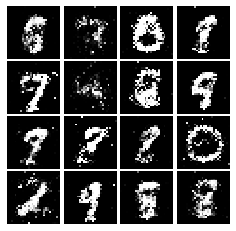

Epoch: 8, Iter: 3920, D: 1.319, G:0.7458


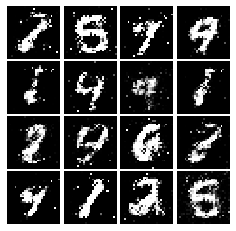

Epoch: 8, Iter: 3940, D: 1.305, G:0.8101


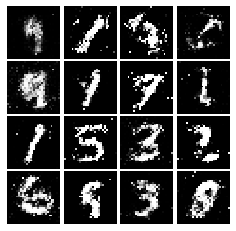

Epoch: 8, Iter: 3960, D: 1.301, G:0.8142


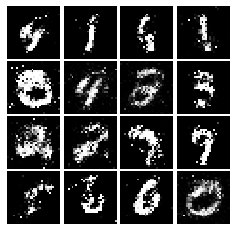

Epoch: 8, Iter: 3980, D: 1.39, G:0.7768


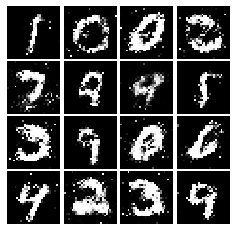

Epoch: 8, Iter: 4000, D: 1.392, G:0.8117


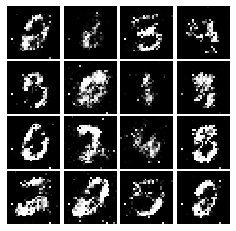

Epoch: 8, Iter: 4020, D: 1.351, G:0.8544


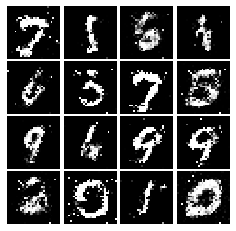

Epoch: 8, Iter: 4040, D: 1.257, G:0.8226


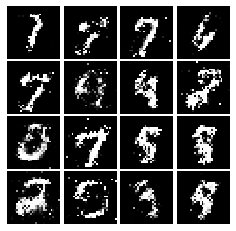

Epoch: 8, Iter: 4060, D: 1.342, G:0.7022


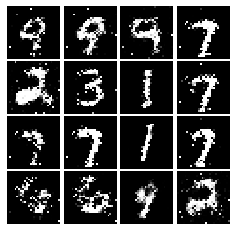

Epoch: 8, Iter: 4080, D: 1.402, G:0.7998


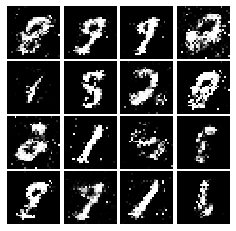

Epoch: 8, Iter: 4100, D: 1.317, G:0.7207


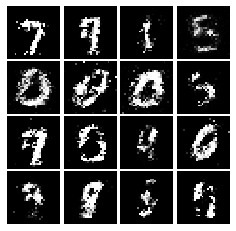

Epoch: 8, Iter: 4120, D: 1.304, G:0.7395


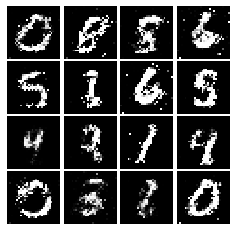

Epoch: 8, Iter: 4140, D: 1.408, G:0.7316


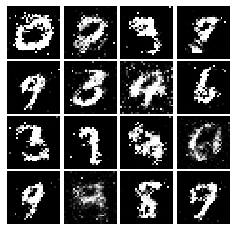

Epoch: 8, Iter: 4160, D: 1.345, G:0.9474


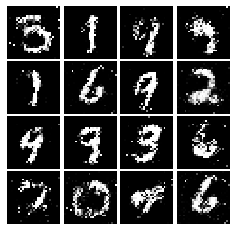

Epoch: 8, Iter: 4180, D: 1.404, G:0.8164


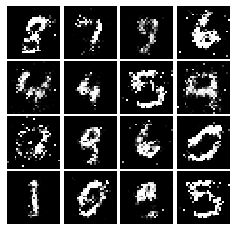

Epoch: 8, Iter: 4200, D: 1.319, G:0.8436


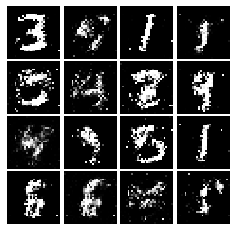

Epoch: 8, Iter: 4220, D: 1.391, G:0.778


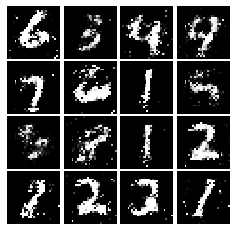

Epoch: 9, Iter: 4240, D: 1.325, G:0.7862


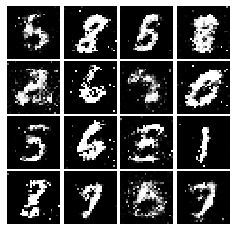

Epoch: 9, Iter: 4260, D: 1.37, G:0.746


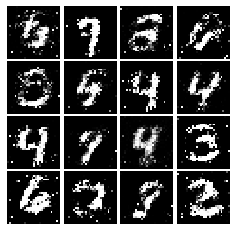

Epoch: 9, Iter: 4280, D: 1.401, G:0.7995


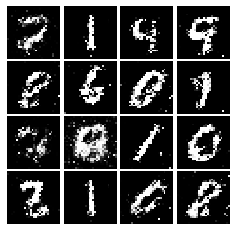

Epoch: 9, Iter: 4300, D: 1.338, G:0.8011


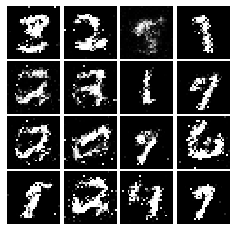

Epoch: 9, Iter: 4320, D: 1.334, G:0.7246


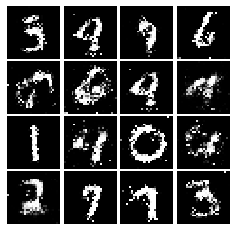

Epoch: 9, Iter: 4340, D: 1.325, G:0.8343


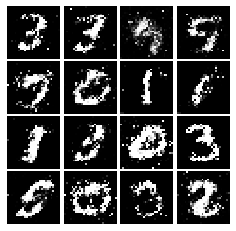

Epoch: 9, Iter: 4360, D: 1.359, G:0.7192


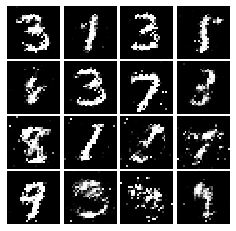

Epoch: 9, Iter: 4380, D: 1.394, G:0.7662


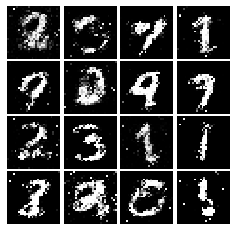

Epoch: 9, Iter: 4400, D: 1.229, G:0.7735


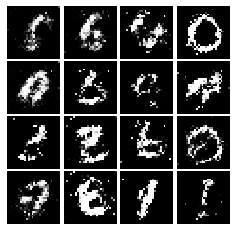

Epoch: 9, Iter: 4420, D: 1.245, G:0.9422


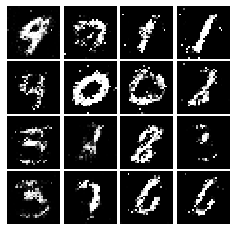

Epoch: 9, Iter: 4440, D: 1.373, G:0.9859


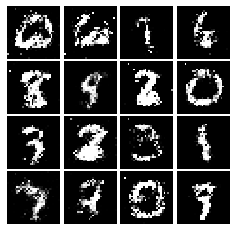

Epoch: 9, Iter: 4460, D: 1.25, G:0.8551


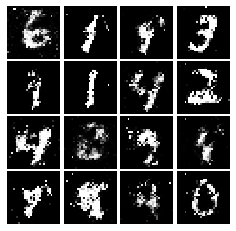

Epoch: 9, Iter: 4480, D: 1.272, G:0.8358


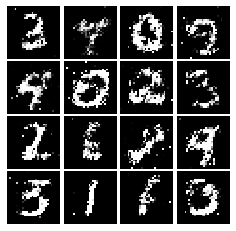

Epoch: 9, Iter: 4500, D: 1.422, G:0.7692


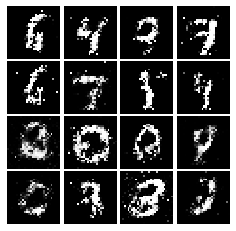

Epoch: 9, Iter: 4520, D: 1.341, G:0.7634


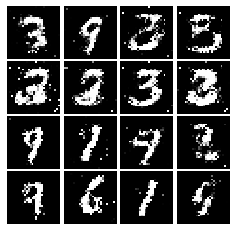

Epoch: 9, Iter: 4540, D: 1.312, G:0.8342


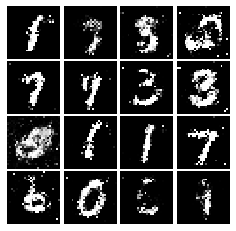

Epoch: 9, Iter: 4560, D: 1.322, G:0.7872


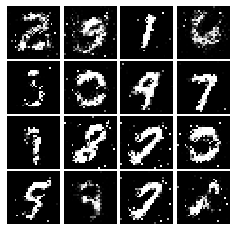

Epoch: 9, Iter: 4580, D: 1.291, G:0.861


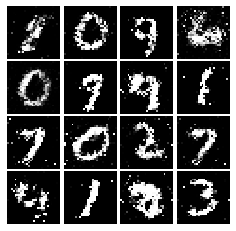

Epoch: 9, Iter: 4600, D: 1.313, G:0.976


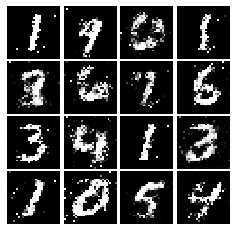

Epoch: 9, Iter: 4620, D: 1.396, G:0.8446


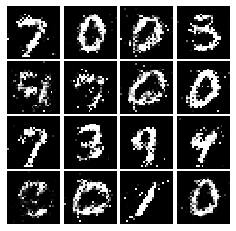

Epoch: 9, Iter: 4640, D: 1.341, G:0.8521


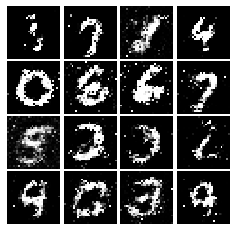

Epoch: 9, Iter: 4660, D: 1.305, G:0.8976


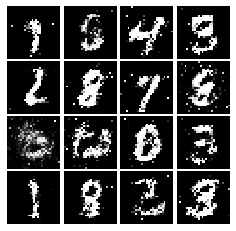

Epoch: 9, Iter: 4680, D: 1.262, G:0.7837


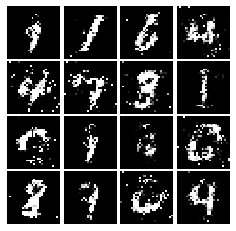

Final images


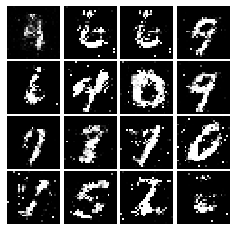

In [38]:
# Make the discriminator
D = discriminator()

# Make the generator
G = generator()

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver, G_solver = get_solvers()

# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss)